<a href="https://colab.research.google.com/github/Brendromero/ProyectSteamGame/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Limpieza de datos**

Antes de ver este documento, recomiendo que vaya a este [link](https://colab.research.google.com/drive/1HxT6sEY1IkJw1RF8oXoS2JqQcsA5-Kj7#scrollTo=_uDX1FAUaqaQ) donde podra ver la limpieza de datos previa a este analisis

# **I. El problema del negocio**

Trabajamos como Data Scientist en Steam, una plataforma multinacional de videojuegos y se nos ha encargado hacer un sistema de recomendacion de videojuegos para los usuarios.

Sin embargo, nos encontramos con los datos impuros. Asi que nuestro primer trabajo sera limpiar esos datos, transformarlos para un analisis mas profundo y hacer el sistema de recomendacion adecuadamente.

# **II. Set de los datos**

La informacion que teniamos previamente eran 3 archivos en formato JSON en las cuales se describe mejor en la etapa del ETL.

En esa etapa pudimos generar un CSV para un analisis mas rapido y optimo.

El CSV generado es [new_steam_games.csv](https://drive.google.com/file/d/1k_YGe-SHccjSaZgHXTm08XZtW_VPpfB5/view?usp=drive_link)

Este archivo CSV contiene las siguientes columnas con las que vamos a trabajar


*   item_id
*   user_id
*   recommend
*   sentiment_analysis
*   genres
*   title
*   developer
*   release_date
*   items_count
*   item_name
*   playtime_forever












# **III. Lectura del dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ast import literal_eval
import ast

In [ ]:
#Me conecto con google colab a mi drive para trabajar con los datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
games = pd.read_csv('/content/drive/MyDrive/datasets/new_steam_games.csv')

In [ ]:
print(games.shape)
games.head()

(25799, 12)


,item_id,user_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever,genres,price,title,developer,release_date
0,43110,76561197970982479,True,2,277.0,Metro 2033,834.0,NaN,NaN,NaN,NaN,NaN
1,239030,js41637,True,2,888.0,"Papers, Please",349.0,"['Adventure', 'Indie']",9.99,"Papers, Please",3909,2013-08-08
2,224500,evcentric,True,2,137.0,Gnomoria,13618.0,"['Indie', 'Simulation', 'Strategy']",14.99,Gnomoria,Robotronic Games,2016-02-23
3,108710,doctr,True,2,541.0,Alan Wake,1185.0,"['Action', 'Adventure']",9.99,Alan Wake,Remedy Entertainment,2012-02-16
4,204300,maplemage,True,2,629.0,Awesomenauts,17589.0,"['Action', 'Free to Play', 'Indie', 'Strategy']",Free To Play,Awesomenauts - the 2D moba,Ronimo Games,2012-08-01


# **IV. Analisis exploratorio**

Veamos las columnas que tenemos disponibles para poder entender las caracteristicas generales de cada una sin olvidar el objetivo principal de la empresa.


In [ ]:
#Tenemos 12 columnas de las cuales 4 son numericas y 8 categoricas
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             25799 non-null  int64  
 1   user_id             25799 non-null  object 
 2   recommend           25799 non-null  bool   
 3   sentiment_analysis  25799 non-null  int64  
 4   items_count         18209 non-null  float64
 5   item_name           18209 non-null  object 
 6   playtime_forever    18209 non-null  float64
 7   genres              21698 non-null  object 
 8   price               21698 non-null  object 
 9   title               21698 non-null  object 
 10  developer           21698 non-null  object 
 11  release_date        21698 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 2.2+ MB


In [ ]:
corr = games.corr()

<ipython-input-6-90ad39f85b78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = games.corr()


In [ ]:
#Grafico la matriz que genere anteriormente
corr.style.background_gradient()

,item_id,recommend,sentiment_analysis,items_count,playtime_forever
item_id,1.000000,-0.151613,-0.013659,0.062136,-0.348598
recommend,-0.151613,1.000000,0.210644,-0.028604,0.067001
sentiment_analysis,-0.013659,0.210644,1.000000,-0.008755,0.017415
items_count,0.062136,-0.028604,-0.008755,1.000000,-0.083213
playtime_forever,-0.348598,0.067001,0.017415,-0.083213,1.000000


In [ ]:
games.describe()

,item_id,sentiment_analysis,items_count,playtime_forever
count,25799.000000,25799.000000,18209.000000,18209.000000
mean,149967.485949,1.301291,123.165962,9226.396233
std,130961.403177,0.953551,193.557206,16733.704007
min,10.000000,0.000000,1.000000,0.000000
25%,730.000000,0.000000,46.000000,508.000000
50%,205100.000000,2.000000,82.000000,1991.000000
75%,248570.000000,2.000000,142.000000,8809.000000
max,527340.000000,2.000000,7762.000000,99888.000000


### Analizando el siguiente grafico de la columna 'genres' podemos observar que las empresas desarrolladoras hacen mas juegos de accion, seguido de los Free to play.

Con respecto a las demas columnas no podemos hacer este tipo de graficas porque columnas como item_id, user_id, developer, title, entre las demas, deberian de darnos un unico valor por lo que nos haria una barra por cada uno de ellos, eso no nos estaria dando ninguna informacion que necesitemos a menos que hagamos conteo de usuarios por generos, que lo veremos mas adelante.

In [ ]:
# Convierto las cadenas de la columna 'genres' en listas reales de Python utilizando ast.literal_eval()
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (SyntaxError, ValueError):
        return np.nan

games['genres'] = games['genres'].apply(safe_literal_eval)

# Utilizo la función explode() para convertir las listas de la columna 'genres' en filas separadas
df_expanded = games.explode('genres')

In [ ]:
print(df_expanded)

       item_id            user_id  recommend  sentiment_analysis  items_count  \
0        43110  76561197970982479       True                   2        277.0   
1       239030            js41637       True                   2        888.0   
1       239030            js41637       True                   2        888.0   
2       224500          evcentric       True                   2        137.0   
2       224500          evcentric       True                   2        137.0   
...        ...                ...        ...                 ...          ...   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25798      440        LydiaMorley       True                   2          NaN   
25798      440        LydiaMorley       True                   2          NaN   

            item_name  play

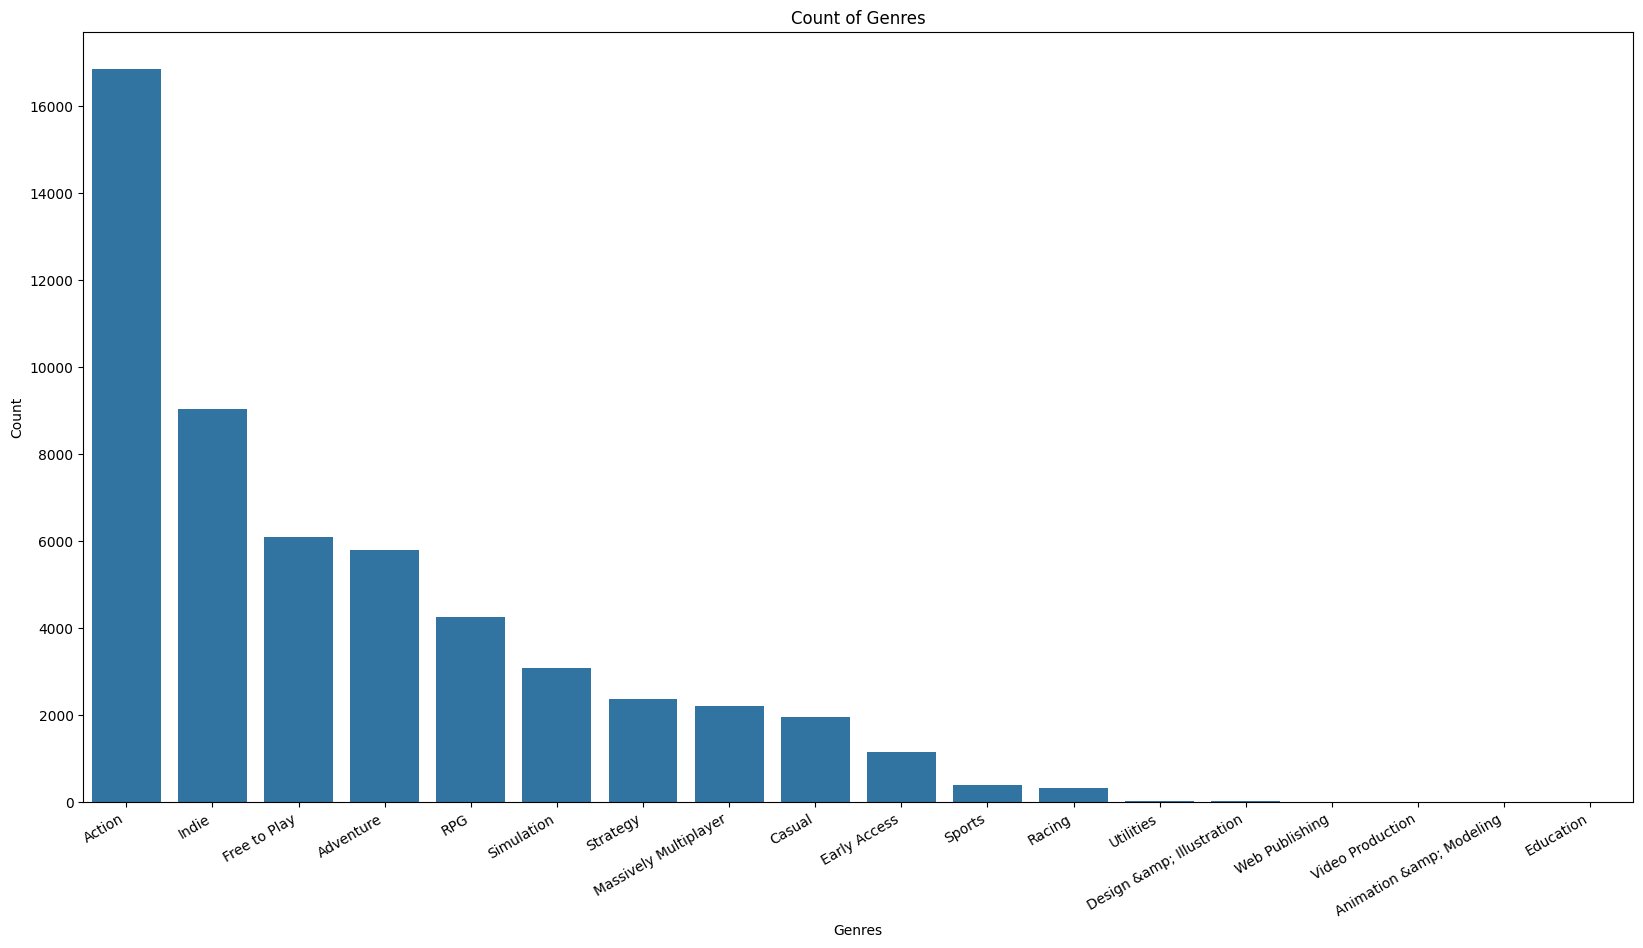

In [ ]:
# Contar la frecuencia de cada género en la columna 'genres'
genre_counts = df_expanded['genres'].explode().value_counts()

# Graficar el conteo de géneros
plt.figure(figsize=(20, 10))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Count of Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.show()

### Con este grafico podemos deducir que los usuarios consumen mas juegos que estan categorizados en accion, pero aun asi hagamos un conteo de cuantos usuarios hay en cada genero

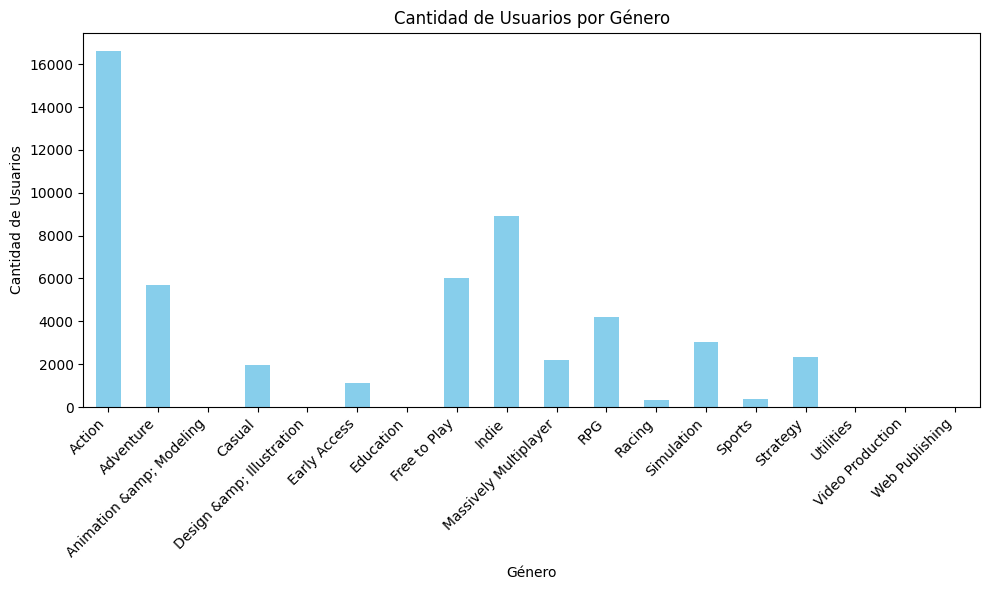

In [ ]:
# Agrupar por género y contar usuarios únicos
genre_user_counts = df_expanded.groupby('genres')['user_id'].nunique()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
genre_user_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Usuarios por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En el grafico de arriba podemos confirmar el porque los desarrolladores hacen mas juegos de accion, los usuarios suelen consumir mas del mismo seguido de los free to play, RPG o Indie

### Sigamos viendo la cantidad de generos lanzados por año

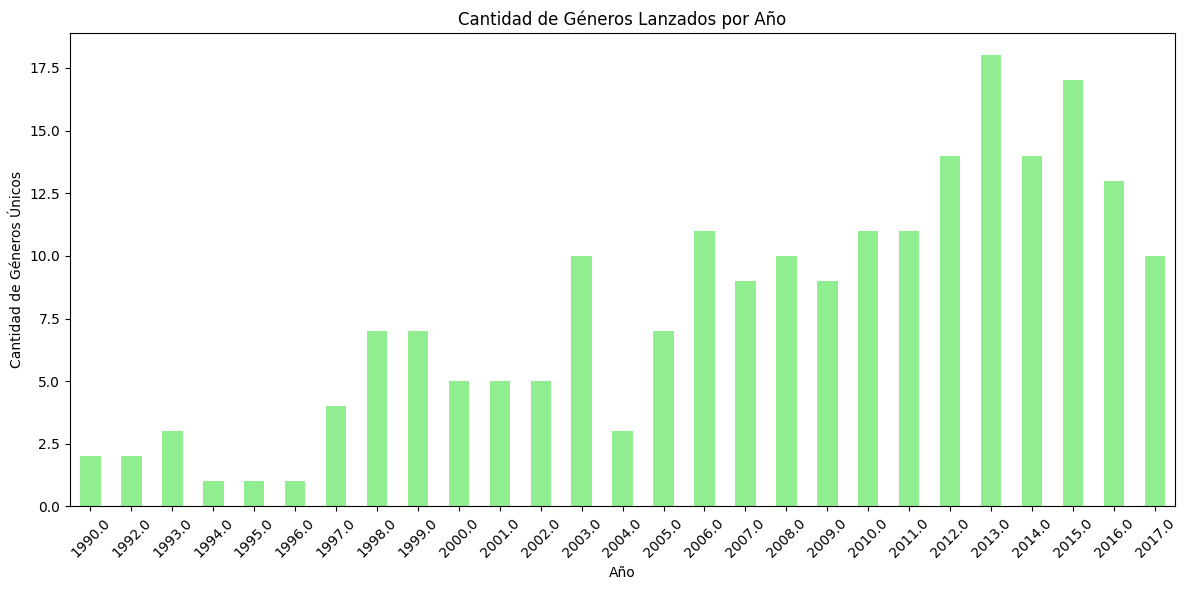

In [ ]:
#Veamos por año los generos que se van sumando

# Convertir la columna 'release_date' a tipo datetime
df_expanded['release_date'] = pd.to_datetime(df_expanded['release_date'])

# Extraer el año de la fecha de lanzamiento
df_expanded['year'] = df_expanded['release_date'].dt.year

# Agrupar por año y contar géneros únicos
year_genre_counts = df_expanded.groupby('year')['genres'].nunique()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
year_genre_counts.plot(kind='bar', color='lightgreen')
plt.title('Cantidad de Géneros Lanzados por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Géneros Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

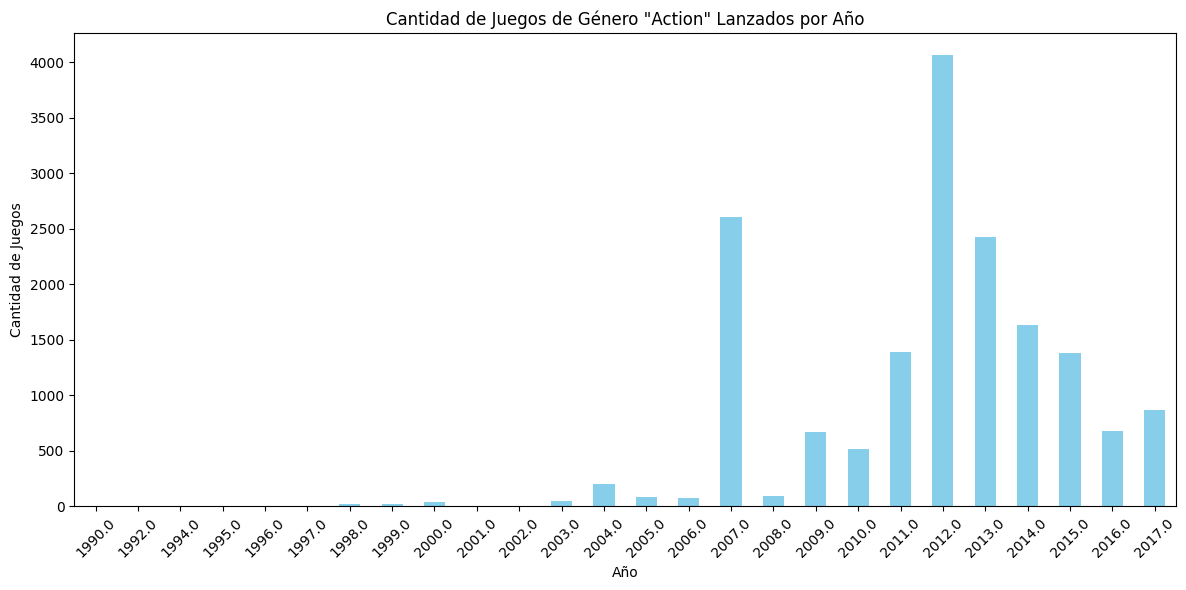

In [ ]:
# Convertir la columna 'release_date' a tipo datetime
df_expanded['release_date'] = pd.to_datetime(df_expanded['release_date'])

# Extraer el año de la fecha de lanzamiento
df_expanded['year'] = df_expanded['release_date'].dt.year

# Eliminar filas con valores NaN en la columna 'genres'
df_expanded.dropna(subset=['genres'], inplace=True)

# Filtrar los juegos del género 'Action'
action_games = df_expanded[df_expanded['genres'].str.contains('Action', case=False)]

# Agrupar los juegos de acción por año y contar la cantidad de juegos únicos por año
action_year_counts = action_games.groupby('year').size()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
action_year_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Juegos de Género "Action" Lanzados por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Con una breve investigación, se pudo conocer que las empresas desarrolladoras optan por este genero porque lleva menos tiempo para desarrollar y ademas por inspiración de otros exitos anteriores de juegos de accion. La mayoria de los jugadores les gusta el tipo de juegos que brindan. En 2012 hubo un incremento debido a ello y a que las consolas como playstation o xbox estaban en su maximo auge.

In [ ]:
# Definir una función para realizar el reemplazo de manera más controlada
def replace_price(text):
    if pd.isnull(text):
        return text
    elif 'Play for Free!' in text:
        return '0.0'
    elif 'Free HITMAN™ Holiday Pack' in text:
        return '0.0'
    elif 'Free Mod' in text:
        return '0.0'
    elif 'Free to Play' in text:
        return '0.0'
    elif 'Free' in text:
        return '0.0'
    else:
        return text

# Aplicar la función a la columna 'price'
df_expanded['price'] = df_expanded['price'].apply(replace_price)

print(df_expanded['price'].unique())

['9.99' '14.99' '0.0' '19.99' '39.99' '2.99' '29.99' '24.99' '34.99'
 '0.99' '4.99' '17.99' '3.99' '59.99' '15.99' '5.99' '11.99' '49.99'
 '12.99' '7.99' '59.95' '6.99' '10.99' '13.98' '1.99' '8.99' '13.99'
 '69.99' '20.0' '44.99' '160.91' '7.0' '18.99' '15.0' '54.99'
 'Third-party' '21.99' '189.96' '79.99' '16.06' '32.99' '771.71' '16.99'
 '13.37' '3.49' '7.49' '0.98' '23.99' '23.96' '139.92' '19.98' '0.49'
 'Play WARMACHINE: Tactics Demo' '99.99' 'Play the Demo' '12.89']


In [ ]:
# Filtrar los valores numéricos en la columna 'price' y convertirlos a tipo float
df_expanded['price'] = pd.to_numeric(df_expanded['price'], errors='coerce')

# Eliminar las filas que contienen NaN (valores que no se pudieron convertir a float)
df_expanded = df_expanded.dropna(subset=['price'])

# Mostrar el DataFrame resultante
print(df_expanded)

       item_id            user_id  recommend  sentiment_analysis  items_count  \
1       239030            js41637       True                   2        888.0   
1       239030            js41637       True                   2        888.0   
2       224500          evcentric       True                   2        137.0   
2       224500          evcentric       True                   2        137.0   
2       224500          evcentric       True                   2        137.0   
...        ...                ...        ...                 ...          ...   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25798      440        LydiaMorley       True                   2          NaN   
25798      440        LydiaMorley       True                   2          NaN   

            item_name  play

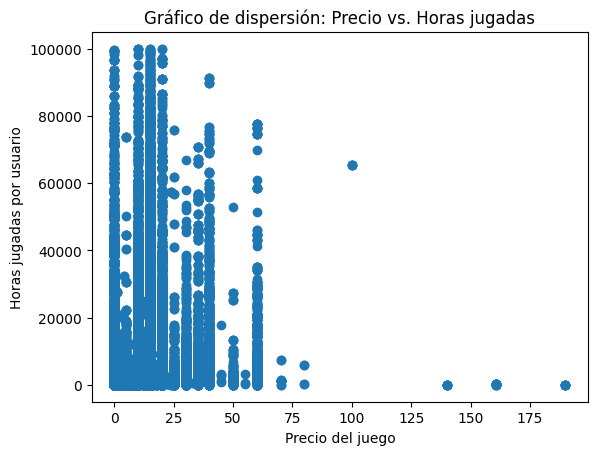

In [ ]:
# Crear un gráfico de dispersión
plt.scatter(df_expanded['price'], df_expanded['playtime_forever'])

# Etiquetas de los ejes y título
plt.xlabel('Precio del juego')
plt.ylabel('Horas jugadas por usuario')
plt.title('Gráfico de dispersión: Precio vs. Horas jugadas')

# Mostrar el gráfico
plt.show()

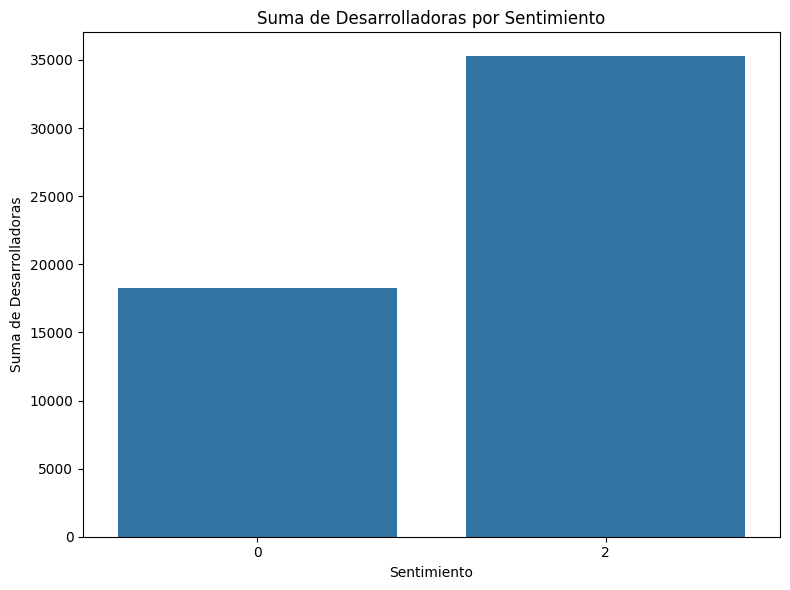

In [ ]:
# Contar el número total de veces que aparece cada desarrolladora con cada tipo de sentimiento
counts = df_expanded.groupby(['developer', 'sentiment_analysis']).size().reset_index(name='count')

# Sumar el conteo de cada desarrolladora por tipo de sentimiento
sum_counts = counts.groupby('sentiment_analysis')['count'].sum().reset_index()

# Crear un gráfico de barras utilizando seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment_analysis', y='count', data=sum_counts)
plt.title('Suma de Desarrolladoras por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Suma de Desarrolladoras')
plt.tight_layout()
plt.show()

Con los graficos hechos, podemos hacer la API en la que debemos tener en consideracion una cosa no menos importante y eso sobre la columna price.

Sobre la etapa anterior intente incorporarlo al analisis, sin embargo se presentaron algunos inconvenientes de los cuales preferi dejar el codigo solo para el grafico y que caso de ser necesario la API se aplicara.

El problema que se presentaba era que, al borrar los NaN, entre otros, se borrara casi el 90% de los datos, algo que al final no podriamos trabajar bien en la API.

En cuanto a la coolumna 'genres' en la etapa anterior habia hecho la expancion pero al probar en la API no habian los resultados suficientes para trabajar, asi que crei que la mejor decision era hacer ese codigo en el transcurso de los endpoints.

Debido al resto, podriamos tomar los graficos e intuir que resultados nos esperaran en la API.